In [2]:
# !pip install tensorflow==2.17.0 sklearn matplotlib seaborn

import numpy as np
import re
import random
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score, matthews_corrcoef,
    roc_auc_score, roc_curve, auc
)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


# Make sure GPU is used if available
print("Physical GPUs:", tf.config.list_physical_devices("GPU"))

Physical GPUs: []


In [3]:
def infer_label(header):
    h = header.lower()
    if h.startswith("human"): return "human"
    if h.startswith("mouse"): return "mouse"
    if "homo" in h or "hs" in h: return "human"
    if "mus" in h or "mm" in h: return "mouse"
    return "human" if "human" in h else "mouse"

def load_fasta(path):
    seqs, labs = [], []
    buf, lab = [], None
    with open(path) as f:
        for line in f:
            line=line.strip()
            if not line: continue
            if line.startswith(">"):
                if buf:
                    seqs.append("".join(buf).upper())
                    labs.append(lab)
                buf=[]
                lab=infer_label(line[1:])
            else:
                buf.append(line)
        if buf:
            seqs.append("".join(buf).upper())
            labs.append(lab)
    return seqs, labs

seqs, labs = load_fasta("Vista_Dataset/vista_sequences.fasta")
print(len(seqs), len(labs))


3408 3408


In [4]:
MAXLEN = 1000

def trim(s):
    if len(s) <= MAXLEN: return s
    mid=len(s)//2
    start=mid-MAXLEN//2
    return s[start:start+MAXLEN]

seqs=[trim(s) for s in seqs]
print("max length:", max(len(s) for s in seqs))

max length: 1000


In [5]:
INTEGER={"A":1,"C":3,"G":2,"T":4}
ATOMIC={"A":70,"C":58,"G":78,"T":66}
EIIP={"A":0.1260,"C":0.1340,"G":0.0806,"T":0.1335}

def encode_map(seq, M):
    return [M.get(nt,0) for nt in seq]

def encode_bfdna(seq):
    c = Counter(seq)
    tot = len(seq)
    f = {b:c.get(b,0)/tot for b in "ACGT"}
    return [f.get(nt,0) for nt in seq]

def encode(seqs, scheme):
    if scheme=="integer": M=INTEGER
    if scheme=="atomic": M=ATOMIC
    if scheme=="eiip": M=EIIP
    if scheme=="bfdna": M=None

    X=np.zeros((len(seqs), MAXLEN), np.float32)
    for i, s in enumerate(seqs):
        if scheme=="bfdna": enc = encode_bfdna(s)
        else: enc = encode_map(s, M)
        X[i,:len(enc)]=enc

    # normalize
    m = X!=0
    if np.any(m):
        mn, mx = X[m].min(), X[m].max()
        if mx>mn:
            X[m]=(X[m]-mn)/(mx-mn)
    return X[...,None]


In [6]:
le = LabelEncoder()
y = le.fit_transform(labs)

idx=np.arange(len(y))
train_idx, test_idx = train_test_split(idx, test_size=0.15, stratify=y, random_state=SEED)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15/0.85, stratify=y[train_idx], random_state=SEED)

In [7]:
def build_fast_model(input_shape):

    inp = layers.Input(shape=input_shape)

    # CNN reduces length drastically
    x = layers.Conv1D(64, 7, padding="same", activation="selu")(inp)
    x = layers.MaxPooling1D(4)(x)

    x = layers.Conv1D(128, 5, padding="same", activation="selu")(x)
    x = layers.MaxPooling1D(4)(x)

    # BiLSTM (light)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(16))(x)

    x = layers.Dense(64, activation="selu")(x)
    x = layers.Dense(32, activation="selu")(x)

    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inp, out)
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
    )
    return model


In [10]:
import os
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        # handle degenerate case where only one class present
        tn = cm[0,0] if cm.shape == (1,1) else 0
        fp = fn = tp = 0
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    CSI = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    G_mean = np.sqrt(recall * specificity)
    MCC = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_true))>1 else 0.0
    Kappa = cohen_kappa_score(y_true, y_pred) if len(np.unique(y_true))>1 else 0.0
    AUC = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else 0.0
    fpr, tpr, _ = (None, None, None)
    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
    except Exception:
        fpr, tpr = None, None
    metrics = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'CSI': CSI,
        'G-mean': G_mean,
        'MCC': MCC,
        'Kappa': Kappa,
        'AUC': AUC,
        'CM': np.array([[int(tn), int(fp)], [int(fn), int(tp)]]),
        'fpr': fpr,
        'tpr': tpr,
    }
    return metrics

def plot_cm(cm, title='Confusion matrix', save_path=None):
    if cm is None:
        print('No confusion matrix to plot')
        return
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    
    if save_path:
        # Ensure directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Confusion Matrix saved to {save_path}")
        
    plt.show()
    plt.close() # Close to free memory

def plot_roc(y_true, y_prob, title='ROC', save_path=None):
    if len(np.unique(y_true)) < 2:
        print('ROC curve requires at least two classes in y_true')
        return
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
    if save_path:
        # Ensure directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"ROC Curve saved to {save_path}")
        
    plt.show()
    plt.close() # Close to free memory


=== Encoding: integer ===


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1000, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 250, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 62, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,409 (380.50 KB)

 Trainable params: 97,409 (380.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5801 - auc: 0.5352 - loss: 0.6776 - val_accuracy: 0.5918 - val_auc: 0.6228 - val_loss: 0.6622
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5847 - auc: 0.5885 - loss: 0.6723 - val_accuracy: 0.5879 - val_auc: 0.6575 - val_loss: 0.6654
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6023 - auc: 0.5965 - loss: 0.6663 - val_accuracy: 0.5898 - val_auc: 0.5617 - val_loss: 0.6716
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5969 - auc: 0.6087 - loss: 0.6609 - val_accuracy: 0.6387 - val_auc: 0.6786 - val_loss: 0.6443
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6363 - auc: 0.6607 - loss: 0.6411 - val_accuracy: 0.6172 - val_auc: 0.6489 - val_loss: 0.6524
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6510 - auc: 0.6767 - loss: 0.6322 - val_accuracy: 0.6270 - val_auc: 0.6923 - val_loss: 0.6317
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/

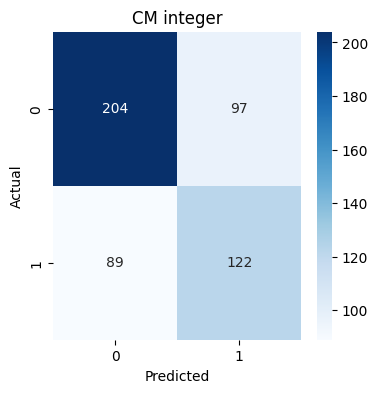

ROC Curve saved to results/integer_roc.png


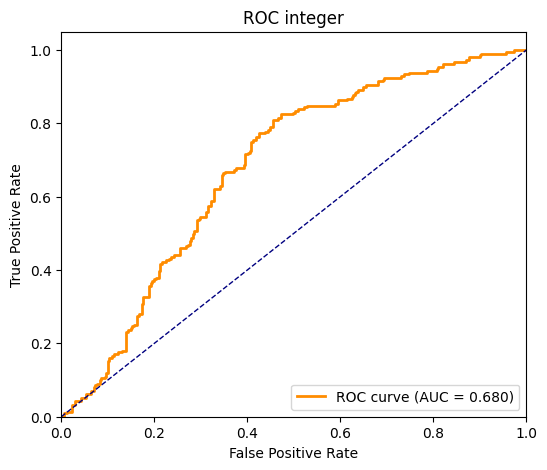


=== Encoding: atomic ===


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1000, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 250, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 62, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,409 (380.50 KB)

 Trainable params: 97,409 (380.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5759 - auc: 0.5396 - loss: 0.6782 - val_accuracy: 0.5996 - val_auc: 0.6559 - val_loss: 0.6702
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5969 - auc: 0.6044 - loss: 0.6653 - val_accuracy: 0.5078 - val_auc: 0.6866 - val_loss: 0.6896
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6158 - auc: 0.6288 - loss: 0.6556 - val_accuracy: 0.5898 - val_auc: 0.6861 - val_loss: 0.6594
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6439 - auc: 0.6770 - loss: 0.6318 - val_accuracy: 0.5605 - val_auc: 0.6640 - val_loss: 0.6841
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6451 - auc: 0.6891 - loss: 0.6230 - val_accuracy: 0.6758 - val_auc: 0.7364 - val_loss: 0.5973
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6640 - auc: 0.7011 - loss: 0.6147 - val_accuracy: 0.6934 - val_auc: 0.7509 - val_loss: 0.5929
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/

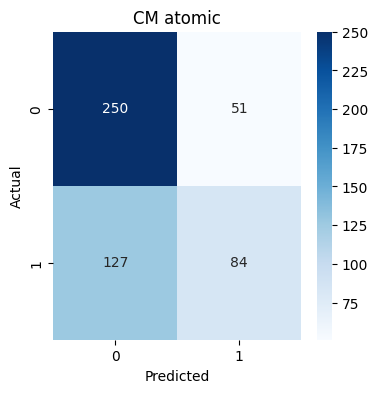

ROC Curve saved to results/atomic_roc.png


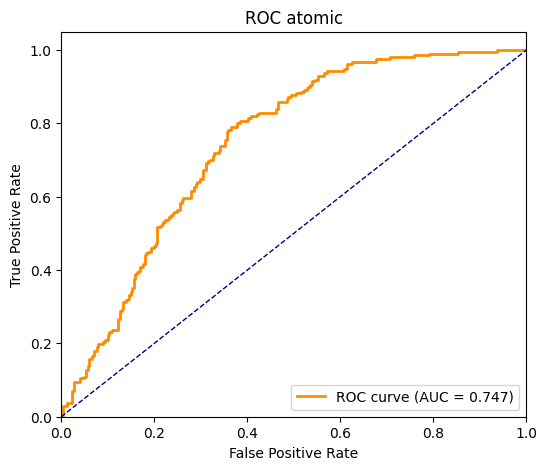


=== Encoding: eiip ===


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 1000, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 250, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 62, 64)         │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,409 (380.50 KB)

 Trainable params: 97,409 (380.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5822 - auc: 0.5477 - loss: 0.6744 - val_accuracy: 0.5977 - val_auc: 0.6042 - val_loss: 0.6656
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5990 - auc: 0.5999 - loss: 0.6637 - val_accuracy: 0.5879 - val_auc: 0.6389 - val_loss: 0.6662
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6166 - auc: 0.6302 - loss: 0.6539 - val_accuracy: 0.6094 - val_auc: 0.6578 - val_loss: 0.6439
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6229 - auc: 0.6508 - loss: 0.6443 - val_accuracy: 0.6133 - val_auc: 0.6743 - val_loss: 0.6302
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6346 - auc: 0.6559 - loss: 0.6417 - val_accuracy: 0.6133 - val_auc: 0.6611 - val_loss: 0.6394
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6464 - auc: 0.6834 - loss: 0.6270 - val_accuracy: 0.6270 - val_auc: 0.6797 - val_loss: 0.6276
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/

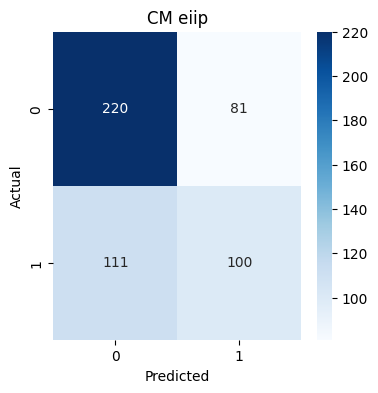

ROC Curve saved to results/eiip_roc.png


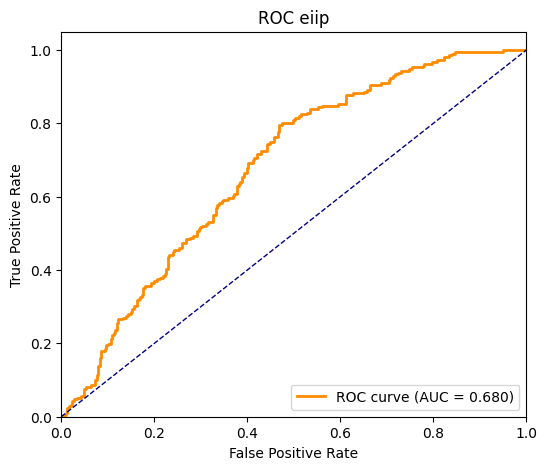


=== Encoding: bfdna ===


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 1000, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 250, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 62, 64)         │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,409 (380.50 KB)

 Trainable params: 97,409 (380.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6174 - auc: 0.6470 - loss: 0.6476 - val_accuracy: 0.6855 - val_auc: 0.7246 - val_loss: 0.6132
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6405 - auc: 0.6727 - loss: 0.6314 - val_accuracy: 0.6738 - val_auc: 0.7262 - val_loss: 0.6094
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6426 - auc: 0.6826 - loss: 0.6240 - val_accuracy: 0.6719 - val_auc: 0.7268 - val_loss: 0.6123
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6493 - auc: 0.6911 - loss: 0.6183 - val_accuracy: 0.6719 - val_auc: 0.7221 - val_loss: 0.6205
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6510 - auc: 0.7000 - loss: 0.6119 - val_accuracy: 0.6797 - val_auc: 0.7286 - val_loss: 0.6044
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6535 - auc: 0.7061 - loss: 0.6050 - val_accuracy: 0.6777 - val_auc: 0.7277 - val_loss: 0.6076
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/

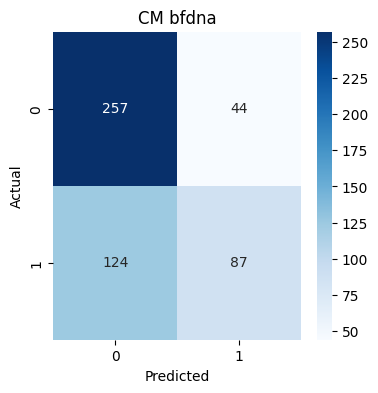

ROC Curve saved to results/bfdna_roc.png


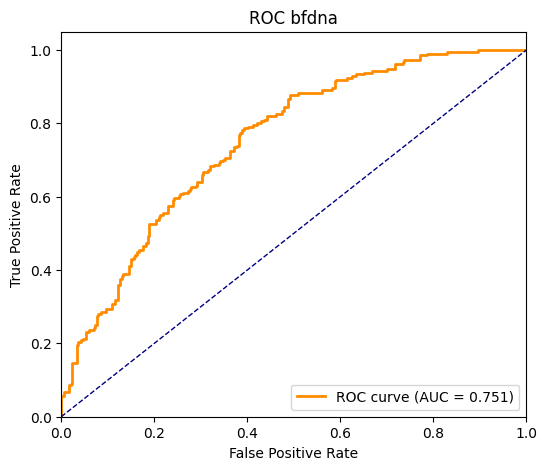

In [ ]:
encodings = ["integer","atomic","eiip","bfdna"]
results={}

for scheme in encodings:
    print("\n=== Encoding:", scheme,"===")

    X = encode(seqs, scheme)
    X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
    y_train_, y_val_, y_test_ = y[train_idx], y[val_idx], y[test_idx]

    model = build_fast_model(X_train.shape[1:])
    model.summary()

    history = model.fit(
        X_train, y_train_,
        validation_data=(X_val, y_val_),
        epochs=100,
        batch_size=32,
        verbose=1,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
    )

    y_prob = model.predict(X_test).ravel()
    m = compute_metrics(y_test_, y_prob)
    results[scheme] = m
    print(m)

    plot_cm(m["CM"], f"CM {scheme}", save_path=f"results/{scheme}_cm.png")
    plot_roc(y_test_, y_prob, f"ROC {scheme}", save_path=f"results/{scheme}_roc.png")


In [12]:
import pandas as pd

rows = []
for scheme, m in results.items():
    rows.append({
        "Encoding": scheme,
        "Accuracy": m["accuracy"],
        "Precision": m["precision"],
        "Recall": m["recall"],
        "F1-score": m["f1"],
        "CSI": m["CSI"],
        "G-mean": m["G-mean"],
        "MCC": m["MCC"],
        "Kappa": m["Kappa"],
        "AUC": m["AUC"],
    })

df_results = pd.DataFrame(rows)
print("\n\nSummary (Scenario 1, all encodings):")
print(df_results.to_string(index=False, float_format=lambda x: f"{x*100:5.2f}%"))




Summary (Scenario 1, all encodings):
Encoding  Accuracy  Precision  Recall  F1-score    CSI  G-mean    MCC  Kappa    AUC
 integer    63.67%     55.71%  57.82%    56.74% 39.61%  62.60% 25.46% 25.45% 68.04%
  atomic    65.23%     62.22%  39.81%    48.55% 32.06%  57.50% 25.54% 24.17% 74.72%
    eiip    62.50%     55.25%  47.39%    51.02% 34.25%  58.86% 21.09% 20.93% 68.04%
   bfdna    67.19%     66.41%  41.23%    50.88% 34.12%  59.33% 30.02% 28.21% 75.12%
